In [1]:
%matplotlib inline
from pylab import *

# Assume a maximum altitude of the UHECR of 10 km and a 10 degree view angle cutoff, 
# so for a given zenith angle th_z, the radius of the area to be considered is 10 km * (tan(thz+10 deg) - tan(10 deg))

thz = np.arange(0., 85., 2.5)

rad = 10.*(np.tan((thz+9.9)*np.pi/180.) - np.tan(thz*np.pi/180.))
for k in range(0,len(thz)):
    th_val = thz[k] + 2.5
    dA_0 = 2. * np.pi * np.sin(th_val*np.pi/180.) * np.cos(th_val*np.pi/180.) * np.pi * rad[k]**2
    print '%1.1f\t%1.1f\t%1.1f'%(thz[k], rad[k], dA_0)


0.0	1.7	2.6
2.5	1.8	5.3
5.0	1.8	8.1
7.5	1.8	11.1
10.0	1.9	14.4
12.5	1.9	17.9
15.0	2.0	21.8
17.5	2.0	26.2
20.0	2.1	31.1
22.5	2.2	36.7
25.0	2.3	43.3
27.5	2.4	50.9
30.0	2.6	59.9
32.5	2.8	70.7
35.0	3.0	83.7
37.5	3.2	99.6
40.0	3.5	119.4
42.5	3.8	144.2
45.0	4.2	175.8
47.5	4.7	216.9
50.0	5.3	271.2
52.5	6.1	344.6
55.0	7.1	446.6
57.5	8.3	592.6
60.0	10.0	809.4
62.5	12.3	1146.5
65.0	15.6	1702.0
67.5	20.6	2690.9
70.0	28.7	4651.5
72.5	43.2	9222.6
75.0	74.7	23292.0
77.5	175.1	103507.9
80.0	5672.9	82205334.8
82.5	-314.6	169570.5


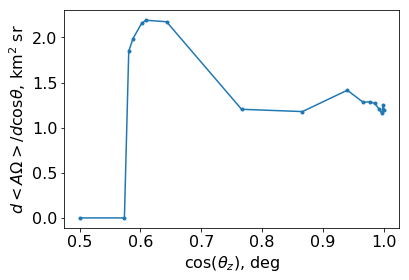

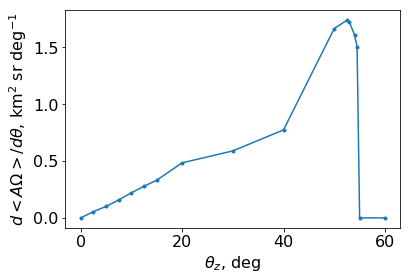

In [2]:
rcParams['font.size'] = 16
# 10^17 eV
th_z     = np.array([0.,   2.5,  5.0,  7.5,  10.,  12.5, 15.,  20.,  30.,  40., 50., 52.5, 53., 54., 54.5, 55., 60.])
rad      = np.array([1.7,  1.8,  1.8,  1.8,  1.9,  1.9,  2.0,  2.1,  2.6,  3.5, 5.3, 6.1, 7.1, 7.1, 7.1, 7.1, 10.])
eff_1e4  = np.array([210., 196., 182., 191., 181., 185., 168., 173., 102., 65., 61., 49., 36., 34., 32., 0.,  0.])

dA_0 = 2. * np.pi * np.cos(th_z*np.pi/180.) * np.pi * rad**2

#plot(th_z, dA_0)
figure(1)
plot(np.cos(th_z*pi/180.), dA_0*eff_1e4*1.e-4, '.-')
ylabel(r'$d<A\Omega>/d\cos\theta$, km$^2$ sr')
xlabel(r'$\cos(\theta_z)$, deg')
figure(2)
plot(th_z, np.sin(th_z*np.pi/180.)*dA_0*eff_1e4*1.e-4, '.-')
xlabel(r'$\theta_z$, deg')
ylabel(r'$d<A\Omega>/d\theta$, km$^2$ sr deg$^{-1}$')

figure(3)


In [3]:
from acceptance import acceptance_sim

'''    
from geometry import Geometry
from xmax_calc import Xmax_calc
from detector_array import Detector_Array
from radio_emission import Radio_Emission
from detector import Detector

def acceptance_sim(radius_km = 10., 
                   num_particles = 1e4, 
                   zenith_angle_deg = None, 
                   log10_energy=17.):

    #SETUP
    geom = Geometry(radius_km, num_particles, zenith_angle_deg)

    XMC = Xmax_calc()
    # I want to provide the energy, cosmic ray ground position and direction, and get the Xmax position
    XMC.get_Xmax_position(log10_energy, geom)
    Xmax_altitude = np.sqrt(XMC.x_max**2 + XMC.y_max**2 + XMC.z_max**2) - XMC.Earth_radius - XMC.detector_altitude_km

    det_arr = Detector_Array()

    rad_em = Radio_Emission(plots=False)

    det = Detector()

    # loop through simulated events:
    trigger = 0
    figure(1)
    for evn in range(0, num_particles): 
        if evn%500 == 0: print evn, trigger

        det_arr.get_distances_and_view_angles(XMC, geom, event=evn)
        # first cut by minimum view angle here.
        if np.min(det_arr.th_view*180./pi)> 10.: continue
    
        th_z = np.arccos(geom.k_z[evn])*180./pi
        E_field,dist = rad_em.radio_beam_model2(th_z, det_arr.th_view, 1.2) # 1.2 is the altitude
        E_field *= 10**(log10_energy-17.)
        x_pol, y_pol, z_pol = rad_em.get_pol(XMC.x_max[evn],  XMC.y_max[evn],  XMC.z_max[evn], geom.x_pos[evn], geom.y_pos[evn], geom.z_pos[evn])
        max_val = np.max(np.array(E_field)*1.e6)
        # then cut by maximum voltage here
        
        V_x = det.Efield_2_Voltage(np.array(E_field*x_pol), th_z)
        V_y = det.Efield_2_Voltage(np.array(E_field*y_pol), th_z)
        V_z = det.Efield_2_Voltage(np.array(E_field*z_pol), th_z)

        V_mag = np.sqrt(V_x**2 + V_y**2 + V_z**2)

        max_val_V = np.max(V_mag)*1.e6
        
        SNR_x = np.abs(V_x)/det.V_rms
        SNR_y = np.abs(V_y)/det.V_rms
        SNR_z = np.abs(V_z)/det.V_rms

        cut_x = SNR_x>5.
        cut_y = SNR_y>5.

        #if evn%100 == 0:
        #    print evn, '%1.1f, %1.2e, %d, %d'%(np.min(det_arr.th_view*180./pi), max_val, np.sum(cut_x), np.sum(cut_y))
        #    print '\t %1.1f %1.1f'%(np.max(SNR_x), np.max(SNR_y))
        if( np.sum(cut_x)>10 or np.sum(cut_y)>10):
            trigger += 1
            print '\t d_core %1.2f'%(np.sqrt(geom.x_pos[evn]**2 + geom.y_pos[evn]**2))
            # will want to save events
        #print '\t %1.2e %1.2e %1.2e'%(x_pol, y_pol, z_pol)
        # then cute by maximum V_mag
        #plot([np.min(det_arr.th_view)*180./pi], [max_val], 'k.')
        #semilogy([np.min(det_arr.th_view)*180./pi], [max([max(SNR_x), max(SNR_y), max(SNR_z)])], 'k.')
        

    #show()
    #print 'trigger', trigger
    #print 10**(log10_energy-17.)
    #print 'det.V_rms', det.V_rms
    return float(trigger)/float(num_particles)
    #figure(figsize=(4,4))
    #plot(geom.x_pos, geom.y_pos, '.', alpha=0.1)
    #xlabel('x, km')
    #ylabel('y, km')
    #figure()
    #hist(geom.x_pos)
    #figure()
    #hist(geom.th_CR*180./pi, bins=np.arange(0.,91., 5.))
    #xticks(np.arange(0.,91., 10.))
    #xlabel('CR Zenith Angle, deg')
    #show()
'''


"    \nfrom geometry import Geometry\nfrom xmax_calc import Xmax_calc\nfrom detector_array import Detector_Array\nfrom radio_emission import Radio_Emission\nfrom detector import Detector\n\ndef acceptance_sim(radius_km = 10., \n                   num_particles = 1e4, \n                   zenith_angle_deg = None, \n                   log10_energy=17.):\n\n    #SETUP\n    geom = Geometry(radius_km, num_particles, zenith_angle_deg)\n\n    XMC = Xmax_calc()\n    # I want to provide the energy, cosmic ray ground position and direction, and get the Xmax position\n    XMC.get_Xmax_position(log10_energy, geom)\n    Xmax_altitude = np.sqrt(XMC.x_max**2 + XMC.y_max**2 + XMC.z_max**2) - XMC.Earth_radius - XMC.detector_altitude_km\n\n    det_arr = Detector_Array()\n\n    rad_em = Radio_Emission(plots=False)\n\n    det = Detector()\n\n    # loop through simulated events:\n    trigger = 0\n    figure(1)\n    for evn in range(0, num_particles): \n        if evn%500 == 0: print evn, trigger\n\n       

cos_thz [ 1.    0.95  0.9   0.85  0.8   0.75  0.7   0.65  0.6   0.55  0.5   0.45
  0.4   0.35  0.3   0.25]


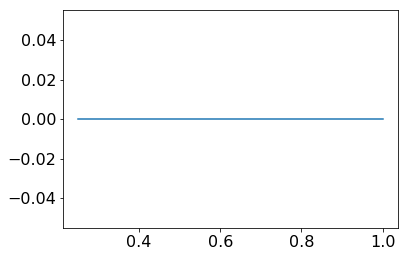

In [4]:
cos_thz = np.arange(1., 0.2, -0.05)
print 'cos_thz', cos_thz
log10_energy = 17.
thz = np.arccos(cos_thz)*180./pi
rad = 10.*(np.tan((thz+9.9)*np.pi/180.) - np.tan(thz*np.pi/180.))
eff = np.zeros(len(cos_thz))
dA_0_dcos_th = np.zeros(len(cos_thz))
for k in range(0,len(cos_thz)):
    continue
    dA_0_dcos_th[k] = 2. * np.pi * cos_thz[k] * np.pi * rad[k]**2
    
    eff_val, thz_array, flat_res = acceptance_sim(radius_km = rad[k],
                  num_particles = 1000,
                  zenith_angle_deg = thz[k],
                  log10_energy = log10_energy)
    eff[k] = eff_vals
    print '%1.2f\t%1.2f\t%1.1f\t%1.2e\t%1.2e\t%1.2e'%(cos_thz[k], thz[k], rad[k], dA_0_dcos_th[k], eff[k], dA_0_dcos_th[k]*eff[k])

plot(cos_thz, dA_0_dcos_th*eff)

In [5]:
print np.sum(dA_0_dcos_th*eff*0.05)

0.0


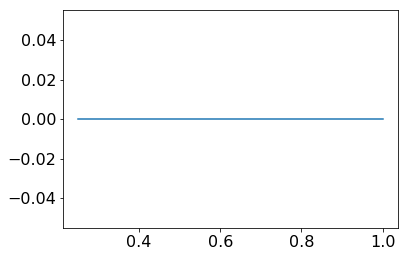

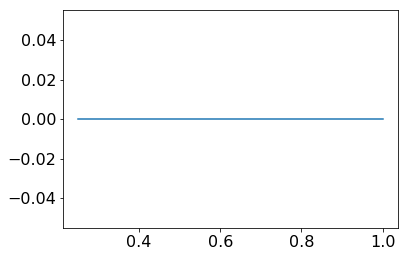

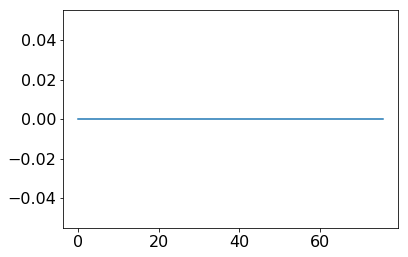

In [6]:
figure(1)
plot(cos_thz, dA_0_dcos_th)
figure(2)
plot(cos_thz, eff)
figure(3)
plot(thz, dA_0_dcos_th*eff*np.sin(thz*pi/180.))


In [7]:
print acceptance_sim(radius_km = 1.,
                     num_particles = 100,
                     zenith_angle_deg = None,
                     log10_energy = 17.,
                     verbose = False)
print pi*pi*1.**2

(0.05, array([ 43.63614185,  10.72034513,   6.66211185,  51.53310452,  15.82291256]), array([[ 0.08720202,  0.12096659],
       [ 0.42952505,  0.        ],
       [ 0.18355659,  0.04473349],
       [ 0.10887658,  0.        ],
       [ 0.32982975,  0.12741967]]))
9.86960440109


In [8]:
#print symbol_that_does_not_exist

In [9]:
'''
print acceptance_sim(radius_km = 20.,
                  num_particles = 10000,
                  zenith_angle_deg = None,
                  log10_energy = 17.)
'''


'\nprint acceptance_sim(radius_km = 20.,\n                  num_particles = 10000,\n                  zenith_angle_deg = None,\n                  log10_energy = 17.)\n'

In [10]:
'''
print acceptance_sim(radius_km = 5.,
                  num_particles = 10000,
                  zenith_angle_deg = None,
                  log10_energy = 17.)
'''

'\nprint acceptance_sim(radius_km = 5.,\n                  num_particles = 10000,\n                  zenith_angle_deg = None,\n                  log10_energy = 17.)\n'

In [11]:
'''
print acceptance_sim(radius_km = 4.,
                     num_particles = 10000,
                     zenith_angle_deg = None,
                     log10_energy = 18., 
                     verbose = True)
'''


'\nprint acceptance_sim(radius_km = 4.,\n                     num_particles = 10000,\n                     zenith_angle_deg = None,\n                     log10_energy = 18., \n                     verbose = True)\n'

16.6 0.7, 0.00e+00 4.72e+00 0.00e+00 0.00e+00
16.7 0.8, 1.09e-03 5.68e+00 6.19e-03 3.41e-03
16.8 0.8, 8.64e-03 6.83e+00 5.90e-02 3.80e-02
16.9 0.9, 1.86e-02 8.21e+00 1.52e-01 1.12e-01
17.0 1.0, 2.60e-02 9.87e+00 2.56e-01 1.89e-01
17.1 1.1, 3.52e-02 1.19e+01 4.17e-01 2.87e-01
17.2 1.2, 4.73e-02 1.43e+01 6.74e-01 4.14e-01
17.3 1.3, 5.71e-02 1.72e+01 9.80e-01 5.27e-01
17.4 1.4, 6.89e-02 2.06e+01 1.42e+00 6.76e-01
17.5 1.6, 7.70e-02 2.48e+01 1.91e+00 8.35e-01
17.6 1.7, 8.41e-02 2.98e+01 2.51e+00 1.06e+00
17.7 1.9, 8.69e-02 3.58e+01 3.11e+00 1.27e+00
17.8 2.1, 8.57e-02 4.31e+01 3.69e+00 1.56e+00
17.9 2.3, 8.47e-02 5.18e+01 4.39e+00 1.90e+00
18.0 2.5, 8.05e-02 6.23e+01 5.01e+00 2.29e+00
18.1 2.8, 7.58e-02 7.49e+01 5.67e+00 2.79e+00
18.2 3.0, 6.82e-02 9.00e+01 6.14e+00 3.02e+00
18.3 3.3, 6.39e-02 1.08e+02 6.91e+00 3.48e+00
18.4 3.6, 5.70e-02 1.30e+02 7.41e+00 3.90e+00
18.5 4.0, 5.22e-02 1.56e+02 8.16e+00 4.43e+00


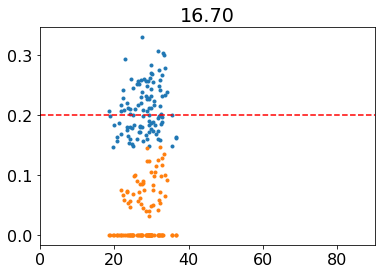

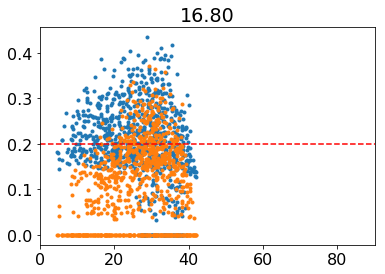

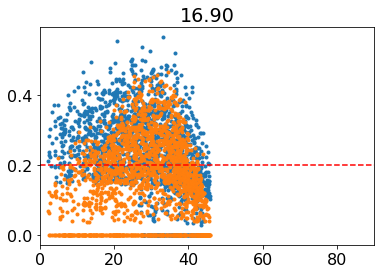

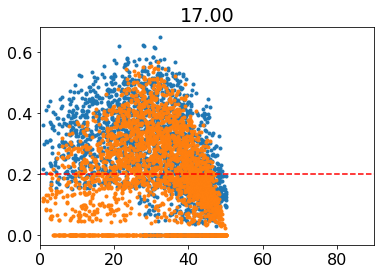

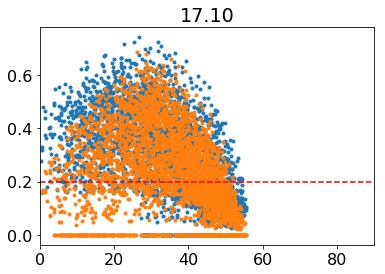

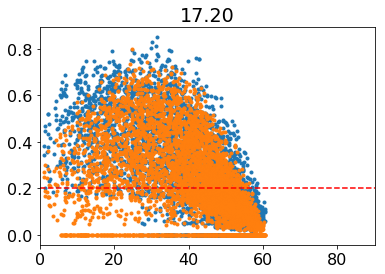

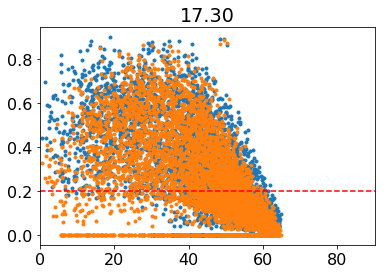

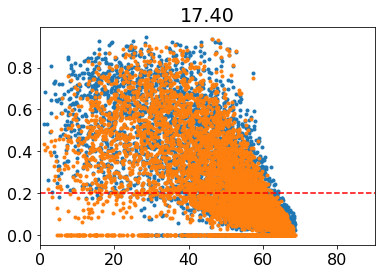

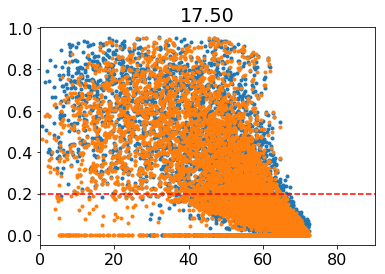

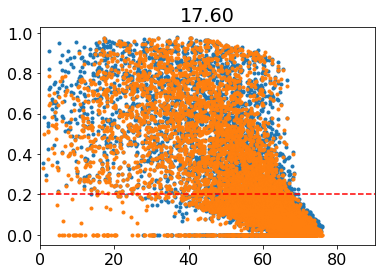

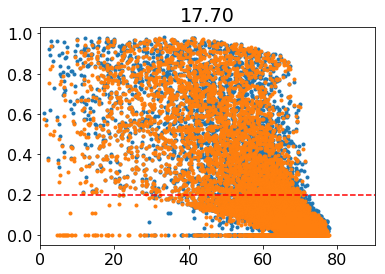

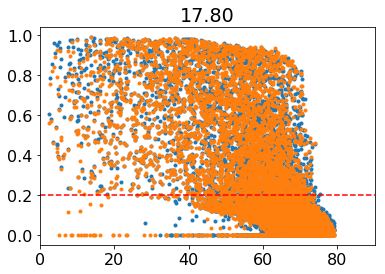

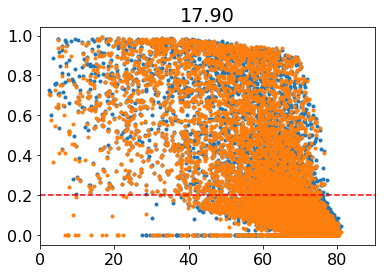

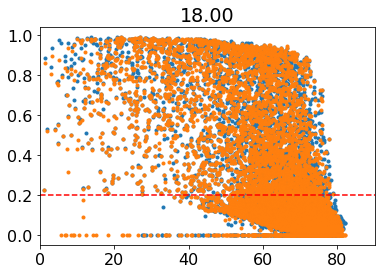

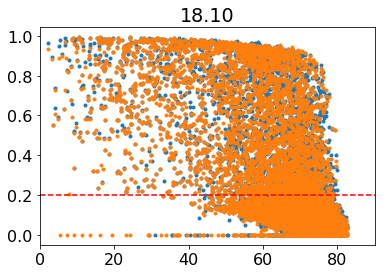

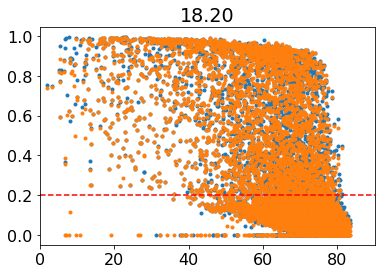

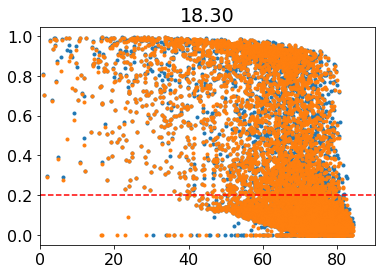

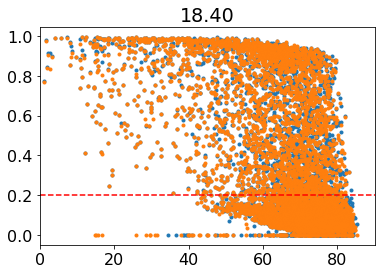

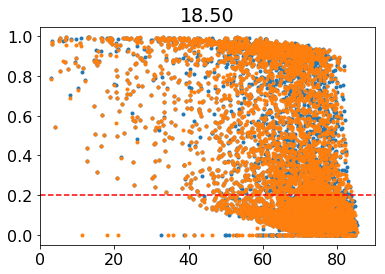

In [12]:
# Voltage SNR of 10 matches
# Need to get right filter response in there.
# Overestimating SNR
e_array = np.arange(16.6, 18.6, 0.1)
acc = np.zeros(len(e_array))
cc=-1
thz_list_of_arrays = []
for en in e_array:
    cc+=1
    rad = (10**(en-17.))**0.4
    A_0 = np.pi**2 * rad**2
    eff, thz_array, flat_res = acceptance_sim(radius_km = rad,
                         num_particles = 100000,
                         zenith_angle_deg = None,
                         log10_energy = en,
                         SNR_thresh = 5.7,
                         N_trig = 12,
                        )
    #print flat_res
    eff_res = 0.
    try:
        figure()
        plot(thz_array, flat_res[:,0], '.')
        plot(thz_array, flat_res[:,1], '.')
        plot([0.,90.], [0.2, 0.2], 'r--')
        xlim(0., 90.)
        #ylim(0.,1.)
        title('%1.2f'%en)
        res_cut = np.logical_or(flat_res[:,0]>0.2, flat_res[:,1]>0.2)
        eff_res = np.sum(res_cut)/float(len(thz_array))
        thz_list_of_arrays.append(thz_array[res_cut])
    except:
        thz_list_of_arrays.append([-1.])
        pass
    acc[cc] = eff*A_0*eff_res
    print '%1.1f %1.1f, %1.2e %1.2e %1.2e %1.2e'%(en, rad, eff, A_0, eff*A_0, acc[cc])

(20,)
[ 16.6  16.7  16.8  16.9  17.   17.1  17.2  17.3  17.4  17.5  17.6  17.7
  17.8  17.9  18.   18.1  18.2  18.3  18.4  18.5]
-3.0


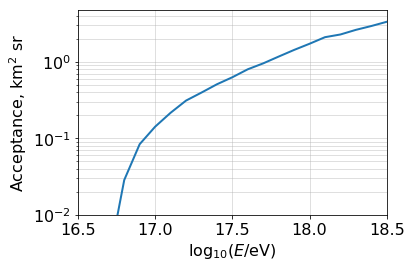

In [20]:
print acc.shape
print e_array
semilogy(e_array, 0.75*acc, lw=2)
xticks(np.arange(16.5, 18.6, 0.5))
xlabel('$\log_{10}(E/\mathrm{eV})$')
ylabel('Acceptance, km$^2$ sr')
grid(True, which='both', alpha=0.5)
xlim(16.5, 18.5)
y1, y2 = ylim()
y1 = 0.01
print np.floor(np.log10(np.min(acc[acc>0.])))
#ylim(10.**np.floor(np.log10(np.min(acc[acc>0.]))), y2)
ylim(y1,y2)
tight_layout()
savefig('Acceptance.pdf')

[  3.98107171e+16   5.01187234e+16   6.30957344e+16   7.94328235e+16
   1.00000000e+17   1.25892541e+17   1.58489319e+17   1.99526231e+17
   2.51188643e+17   3.16227766e+17   3.98107171e+17   5.01187234e+17
   6.30957344e+17   7.94328235e+17   1.00000000e+18   1.25892541e+18
   1.58489319e+18   1.99526231e+18   2.51188643e+18   3.16227766e+18]
[  0.           0.19896932   1.5063729    3.77234382   6.03293883
   8.05843677   9.78301383  11.07712997  12.05694438  12.77100633
  13.30634521  13.6837095   13.9566592   14.15325878  14.29289312
  14.39322629  14.45741729  14.50092943  14.52972771  14.54902434]


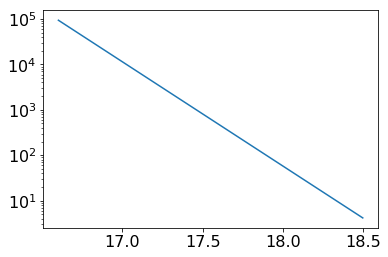

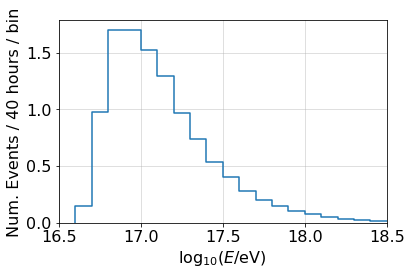

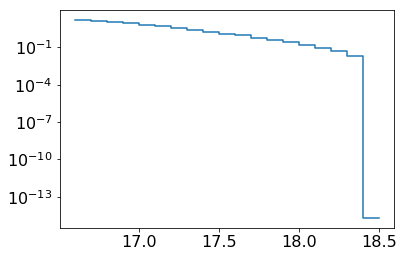

In [19]:
def flux(energy_array_eV):
    # parameterization from Auger ICRC 2017
    J0 = 2.7513872e-19 # km^-2 sr^-1 yr^-1 eV^-1
    E_ankle = 5.08e18  # eV
    E_s = 3.9e19       # eV
    gam_1 = 3.293
    gam_2 = 2.53
    dgam  = 2.5
    flux = np.ones(len(energy_array_eV))
    cut_1 = energy_array_eV<=E_ankle
    cut_2 = energy_array_eV>E_ankle

    flux[cut_1]=J0*(energy_array_eV[cut_1]/E_ankle)**-gam_1
    flux[cut_2]=J0*(energy_array_eV[cut_2]/E_ankle)**-gam_2 * (1.+(E_ankle/E_s)**dgam)/((1.+(energy_array_eV[cut_2]/E_s)**dgam))
    return flux

print 10**e_array
flx = flux(10**e_array)

semilogy(e_array, flx*10**e_array)
T_live = 40./(365.25*24.)

figure()
plot(e_array, 0.75*flx * 10**e_array * acc * np.log(10.)*0.1 * T_live, drawstyle='steps')
xlabel('$\log_{10}(E/\mathrm{eV})$')
ylabel('Num. Events / 40 hours / bin')
grid(True, which='both', alpha=0.5)
xlim(16.5, 18.5)
y1, y2 = ylim()
ylim(0., y2)
tight_layout()
savefig('Energy_Distrib.pdf')

d_log_10_E = 0.1
figure()
semilogy(e_array, ( np.sum(flx * 10**e_array * acc) - np.cumsum(flx * 10**e_array * acc) )*np.log(10.)* d_log_10_E * T_live, drawstyle='steps')

print np.cumsum(flx * 10**e_array * acc)*np.log(10.)* d_log_10_E * T_live



[ 0.35801964  0.48387097  0.55859813  0.56219081  0.5354142   0.56972477
  0.57671233  0.56636364  0.6182716   0.58688525  0.6         0.59
  0.52727273]
0.566363636364


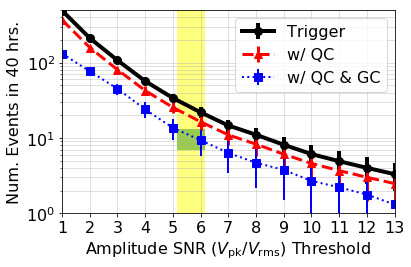

In [15]:
SNR_thresh = [1., 2., 3., 4., 5.,   6.,     7.,   8.,   9.,  10.,   11,   12 , 13]
#Num_events = [51.3, 33.1, 22.2, 16.6, 12.6, 8.95, 8.12, 5.8, 4.83]
Num_events = [488.8, 210.8, 107.0, 56.6, 33.8, 21.8, 14.6,  11.0,  8.1, 6.1,   4.9, 4.0, 3.3]
SNR_thresh_cut = [1.,   2.,    3.,   4.,   5.,  6., 7.,     8.,  9.,    10.,  11.,   12., 13.]
#Num_events_cut = [17.5, 11.05, 7.73, 5.71, 4.34, 3.5, 2.72, 2.02, 1.74, 1.39, 1.18, 1.03, 0.81  ]
Num_events_cut = [175., 102., 59.77, 31.82, 18.097, 12.42, 8.42, 6.23, 5.008, 3.58, 2.94, 2.36, 1.74  ]


#Num_events_cut = 0.75*np.array(Num_events_cut)
Num_events_cut = np.array(Num_events_cut)
Num_events = np.array(Num_events)

print Num_events_cut / Num_events
print np.median(Num_events_cut / Num_events)

ax = subplot(111)
ax.set_yscale('log')
#plot(SNR_thresh, Num_events, 'ko-', label='Trigger')
#plot(SNR_thresh, 0.75*Num_events, 'bo--', label='Trigger')
#plot(SNR_thresh_cut, 0.75*Num_events_cut, 'rs:', label='With Power\nin Gaussian Cut')
#plot(SNR_thresh_cut, Num_events_cut, 'rs--', label='With Power\nin Gaussian Cut')
errorbar(SNR_thresh_cut, Num_events, yerr = np.sqrt(Num_events_cut), fmt='ko-', lw=4, ms=8, label='Trigger')
errorbar(SNR_thresh_cut, 0.75*Num_events, yerr = np.sqrt(Num_events_cut), fmt='r^--', lw=3, ms = 8, label='w/ QC')
errorbar(SNR_thresh_cut, 0.75*Num_events_cut, yerr = np.sqrt(Num_events_cut), fmt='bs:', lw=2, ms = 8, label='w/ QC & GC')
#errorbar(SNR_thresh_cut, Num_events, yerr = np.sqrt(Num_events), fmt='ko-')
#fill_between([1.5, 3.5], 1., 500., facecolor='yellow', alpha=0.5)
#fill_between([1.5, 3.5], (10.-np.sqrt(10.)), (10.+np.sqrt(10.)), facecolor='green', alpha=0.4)
fill_between([5.66-0.5, 5.66+0.5], 1., 500., facecolor='yellow', alpha=0.5)
fill_between([5.66-0.5, 5.66+0.5], (10.-np.sqrt(10.)), (10.+np.sqrt(10.)), facecolor='green', alpha=0.4)
xlabel('Amplitude SNR ($V_\mathrm{pk}/V_\mathrm{rms}$) Threshold')
ylabel('Num. Events in 40 hrs.')
legend(loc=0)
#savefig('')
ylim(1., 500.)
#yticks(np.arange(0.,60.1,5.))
xticks(np.arange(1.,13.1, 1.))
xlim(1., 13.)
grid(True, alpha=0.5, which='both')
tight_layout()
savefig('Num_events.pdf')

16.6
16.7
16.8
16.9
17.0
17.1
17.2
17.3
17.4
17.5
17.6
17.7
17.8
17.9
18.0
18.1
18.2
18.3
18.4
18.5


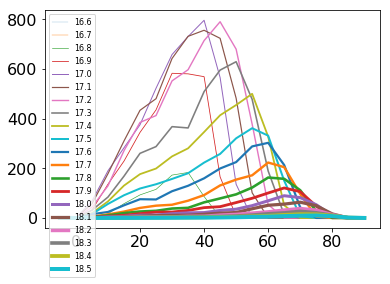

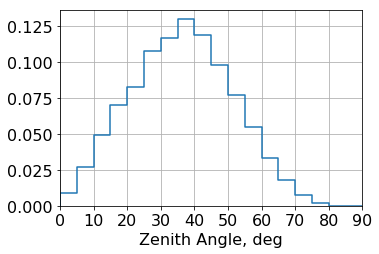

In [16]:
wh, b = np.histogram(thz_list_of_arrays[0], bins = np.arange(-10., 91., 5.))
wh = wh*0.
cc=0
for k in range(len(thz_list_of_arrays)):
    weight = flx[k] * 10**e_array[k] * acc[k] * np.log(10.)*0.1 * T_live
    h, b = np.histogram(thz_list_of_arrays[k], bins = np.arange(-10., 91., 5.))
    wh += h*weight
    plot(b[1:], h*weight, lw = (cc+1)*0.2, label=e_array[k])
    print e_array[k]
    cc+=1
legend(loc=2, fontsize=8)
figure()
plot(b[1:], wh/np.sum(wh), drawstyle='steps')
y1, y2 = ylim()
ylim(0., y2)
xlim(0.,90.)
xticks(np.arange(0.,91.,10.))
grid(True, which='both')
xlabel('Zenith Angle, deg')
subplots_adjust(left=0.2, right=0.9, bottom=0.2)
savefig('Zenith_angle_distrib.pdf')

Text(0,0.5,u'CDF')

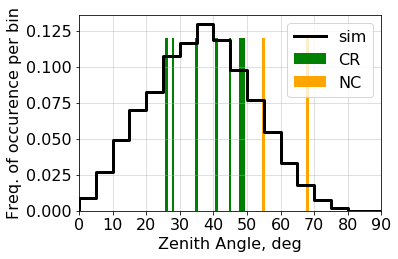

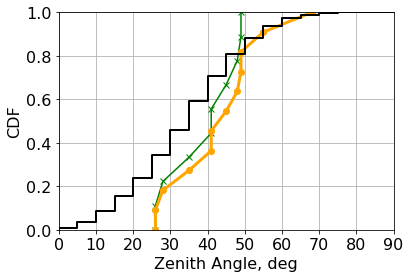

In [21]:
figure()
plot(b[1:], wh/np.sum(wh), 'k-', lw=3, drawstyle='steps', label='sim')
y1, y2 = ylim()
ylim(0., y2)
xlim(0.,90.)
xticks(np.arange(0.,91.,10.))
grid(True, which='both', alpha=0.5)
xlabel('Zenith Angle, deg')
ylabel('Freq. of occurence per bin')
subplots_adjust(left=0.2, right=0.9, bottom=0.2)
savefig('zen_angle_distrib.pdf')

#CR_vals = 90.-np.array([61.67, 47.93, 40.26, 63.76, 42.43, 63.21, 40.03, 44.30, 54.86, 48.83])
#NC_vals = 90. - np.array([20.2, 33.8])

CR_vals = np.array([28., 41., 49., 26., 48., 26., 49., 45., 35., 41.])
NC_vals = np.array([55., 68.])

bar(CR_vals, 0.12*np.ones(len(CR_vals)), align='center', color='green', alpha=1.0,  label='CR')
bar(NC_vals, 0.12*np.ones(len(NC_vals)), align='center', color='orange', alpha=1.0, label='NC')
legend()
savefig('Zenith_angle_distrib_w_data.pdf')

measured_vals = np.concatenate([CR_vals, NC_vals])

'''%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%'''

figure()
u = (np.cumsum(np.ones(len(CR_vals)))-1)/float(len(CR_vals)-1)
plot(np.sort(CR_vals),u, 'gx-')

u = (np.cumsum(np.ones(len(measured_vals)))-1)/float(len(measured_vals)-1)
plot(np.sort(measured_vals),u, 'o-', color='orange', lw=3)

plot(b[1:], np.cumsum(wh/np.sum(wh)), 'k-', drawstyle='steps', lw=2)
ylim(0., 1.)
xlim(0.,90.)
xticks(np.arange(0.,91.,10.))
grid(True, which='both')
xlabel('Zenith Angle, deg')
ylabel('CDF')

#from scipy import stats
#tats.ks_2samp(CR_vals, rvs4)